In [1]:
from datetime import date
from datetime import datetime
import time
import os
import warnings

import pandas as pd
import random
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

In [2]:
# Set model hyperparameters
random_state = 42
n_estimators = 50
min_samples_leaf = 3

# Active Learning params
init_points = 100
n_iter = 500
# Define black box function to optimize (Expected_Improvement, Expected_Improvement_r, Expected_Improvement_min,
# Expected_Improvement_min_r, CustomFunction_1)
black_box_func = 'Expected_Improvement'

In [3]:
#Set save directory
results_dir = "Bayes_Opt_Results_Atomic_params"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [4]:
#Import and check data
data_file = r'C:\Users\ezxac5\OneDrive - The University of Nottingham\Tasks\papers\Paper_2\Experimental_data\Combined_Wright_et_al_RTZr_LT_AL_rmv_outliers.csv'
data = pd.read_csv(data_file)                            #Import CSV Data

In [5]:
data.describe()

,LaA,NdA,SmA,GdA,EuA,YbA,YA,DyA,HoA,ErA,...,RB,RA/RB,MA,MB,P,a2,Density,RD,Entropy_conf,TC
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0,38.000000,38.0,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,23.000000,38.000000,38.000000
mean,0.259773,0.037775,0.159223,0.235335,0.096115,0.070029,0.095614,0.0,0.003897,0.0,...,0.704660,1.531805,144.287617,101.254357,0.921053,10.530435,6.844247,96.934783,1.371461,1.898691
std,0.278094,0.094791,0.266733,0.260737,0.156854,0.178090,0.212686,0.0,0.024025,0.0,...,0.023479,0.053654,15.621466,18.270408,0.273276,0.101182,0.637901,1.779583,0.716359,0.266631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.630417,1.416667,98.905774,68.268917,0.000000,10.296672,5.609314,93.500000,0.171259,1.360000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.687604,1.498781,140.267847,91.224000,1.000000,10.457440,6.453740,95.700000,0.783088,1.690500
50%,0.200000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.720000,1.526134,149.765286,91.224000,1.000000,10.544629,6.741417,97.500000,1.241302,1.970000
75%,0.400000,0.000000,0.250000,0.351083,0.185714,0.000000,0.000000,0.0,0.000000,0.0,...,0.720000,1.559863,153.483654,109.072750,1.000000,10.601419,7.404570,98.100000,1.800131,2.096000
max,1.000000,0.357100,1.000000,1.000000,0.500000,0.800000,0.800000,0.0,0.148100,0.0,...,0.720000,1.690945,166.213094,134.857000,1.000000,10.728332,7.795366,100.000000,2.939007,2.290000


In [6]:
data_input = data[['RA', 'RB', 'MA', 'MB', 'Entropy_conf']]      # Specify input descriptors. For utility purposes.
target = data['TC']                                              # Specify output descriptors. For utility purposes.
df = data[['RA', 'RB', 'MA', 'MB', 'Entropy_conf', 'TC']]        # DataFrame containing all relevant inputs and target variable. For use in the main process.

In [15]:
print(data['Comp'])

0                                              La2Zr2O7
1                                              Sm2Zr2O7
2                                    La2(Zr1/2Hf1/2)2O7
3                          Sm2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7
4                          Gd2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7
5                     (Sm1/2Gd1/2)2(Zr1/3Hf1/3Ti1/3)2O7
6                     (Gd1/2Eu1/2)2(Zr1/3Hf1/3Ti1/3)2O7
7                     (La1/2Pr1/2)2(Zr1/3Hf1/3Sn1/3)2O7
8                     (Gd1/2Eu1/2)2(Zr1/3Hf1/3Sn1/3)2O7
9                     (La1/3Nd1/3Pr1/3)2(Zr1/2Hf1/2)2O7
10                    (Sm1/3Gd1/3Eu1/3)2(Zr1/2Hf1/2)2O7
11               (Sm1/3Gd1/3Eu1/3)2(Zr1/3Hf1/3Sn1/3)2O7
12          (Sm1/3Gd1/3Eu1/3)2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7
13     (Sm1/4Gd1/4Eu1/4Yb1/4)2(Zr1/4Hf1/4Sn1/4Ti1/4)2O7
14          (Sm1/3Gd1/3Eu1/3)2(Zr1/6Hf1/6Sn1/6Ti1/2)2O7
15       (Sm1/3Gd1/3Eu1/3)2(Zr1/12Hf1/12Sn1/12Ti3/4)2O7
16          (Sm1/4Gd1/4Eu1/4Yb1/4)2(Zr1/4Hf1/4Ti1/2)2O7
17                         (Sm3/4Yb1/4)2(Zr1/2Ti

In [12]:
data_input_temp = data_input[:34]
target_temp = target[:34]

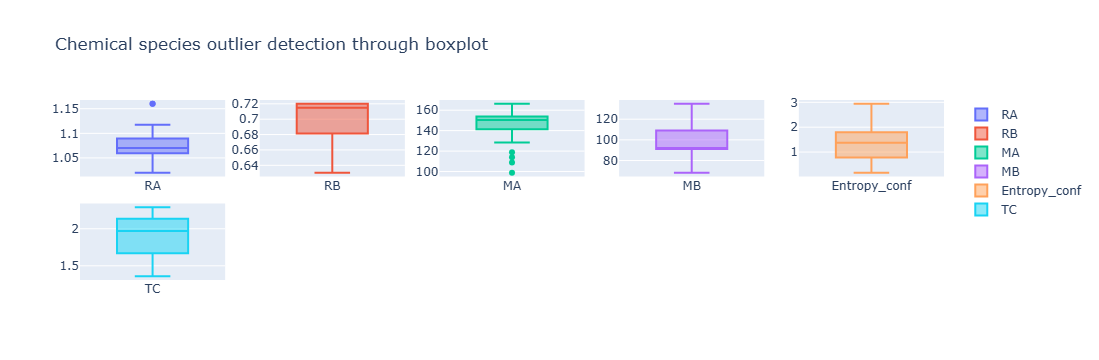

In [13]:
# Box plot to identify outliers
rows_c = 2
cols_c = 5
fig = make_subplots(rows = rows_c, cols = cols_c)
row_no = col_no = 1

for col in data_input.columns:
    fig.add_trace(
    go.Box(y=data_input_temp[col], name = col),
    row = row_no,
    col = col_no,
    )
    col_no += 1
    if col_no % (cols_c+1) == 0:
        row_no += 1
        col_no = 1
        
fig.add_trace(go.Box(y=target_temp, name='TC'),
             row = row_no,
             col = col_no)
        
fig.update_layout(title_text = "Chemical species outlier detection through boxplot")
fig.show()
fig.write_html(results_dir + '\\' + f"Input_param_outlier_detection.html")

In [10]:
print(df[:34])

          RA        RB          MA          MB  Entropy_conf        TC
0   1.160000  0.720000  138.905470   91.224000      0.171259  2.140000
1   1.079000  0.720000  150.360000   91.224000      0.171259  2.040000
2   1.160000  0.715000  138.905470  134.857000      0.801393  2.290000
3   1.079000  0.681250  150.360000  109.072750      1.431527  1.730000
4   1.053000  0.681250  157.250000  109.072750      1.431527  1.580000
5   1.066000  0.678333  153.805000  105.860333      1.800131  1.470000
6   1.059500  0.678333  154.607000  105.860333      1.800131  1.520000
7   1.060000  0.706667  139.906560  129.474667      1.800131  2.240000
8   1.059500  0.706667  154.607000  129.474667      1.800131  2.240000
9   1.076333  0.715000  141.351707  134.857000      1.800131  2.160000
10  1.066000  0.715000  153.191333  134.857000      1.800131  1.970000
11  1.066000  0.706667  153.191333  129.474667      2.168736  2.210000
12  1.066000  0.681250  153.191333  109.072750      2.430265  1.670000
13  1.

In [150]:
df.min(axis=0)

RA               1.020000
RB               0.630417
MA              98.905774
MB              68.268917
Entropy_conf     0.171259
TC               1.360000
dtype: float64

In [151]:
df.max(axis=0)

RA                1.160000
RB                0.720000
MA              166.213094
MB              134.857000
Entropy_conf      2.939007
TC                2.290000
dtype: float64

In [152]:
# Set bounds for active learning

# Fixing RA range between radius of La and Yb
RA_pbound = [0.985, 1.16]

# Fixing RB to the ionic radii of Zr
RB_pbound = [0.72, 0.72]

# Fixing RA/RB range from Yb to upper limit for stable pyrohclore phase
RA_RB_pbound = [1.368, 1.78]

# Fixing MA range between mass of La and Yb
MA_pbound = [138.90547, 173.04]

# Fixing MB to mass of Zr
MB_pbound= [91.224, 91.224]

# Ensuring single phase
P_pbound = [0, 1]

# Lattice parameter min from Wright et al. and max set to value for La2Zr2O7 from Wan et al. as it is higher
a_2_pbound = [10.221114, 10.81]

# Min density of La2Zr2O7 and max from Wright et al.
Density_pbound = [6.05, 7.795366]

# Max density set slightly above the density for equimolar, 9 element compositions (2.6)
Entropy_pbound = [0, 3]

In [153]:
#Set bounds for normalizing data (Output only)


# Fixing RA range between radius of La and Yb
RA_bound = [0.985, 1.16]

# RB min/max set to radii of Ti and Ce, respectively
RB_bound = [0.605, 0.87]

# Fixing RA/RB range from Yb to upper limit for stable pyrohclore phase
RA_RB_bound = [1.368, 1.78]

# Fixing MA range between mass of Y and Yb
MA_bound = [88.90585, 173.04]

# Fixing MB range to min/max of Wright et al.
MB_bound= [47.867, 134.857]

# 0 for Flourite and 1 for Pyrochlore phase
P_bound = [0, 1]

# Lattice parameter min from Wright et al. and max set to value for La2Zr2O7 from Wan et al. as it is higher
a_2_bound = [10.221114, 10.81]

# Min density of La2Zr2O7 and max from Wright et al.
Density_bound = [6.05, 7.795366]

# Max density set slightly above the density for equimolar, 9 element compositions (2.6)
Entropy_bound = [0, 3]

# Thermal Conductivity range set between min/max of Wright et al.
TC_bound = [1.36, 2.88]

min_values = [RA_bound[0], RB_bound[0], MA_bound[0], MB_bound[0], Entropy_bound[0], TC_bound[0]]

max_values = [RA_bound[1], RB_bound[1], MA_bound[1], MB_bound[1], Entropy_bound[1], TC_bound[1]]

normalization_vals = {'RA':(RA_bound[0], RA_bound[1]), 'RB':(RB_bound[0], RB_bound[1]), \
                      'MA':(MA_bound[0], MA_bound[1]), 'MB':(MB_bound[0], MB_bound[1]), \
                      'Entropy_conf':(Entropy_bound[0], Entropy_bound[1])}

In [154]:
#normalize data
df_nump = df.to_numpy()

scaler = MinMaxScaler()

scaler.fit([min_values, max_values])

df_nump = scaler.transform(df_nump)

In [155]:
df_input = df_nump[:,0:5] # Set input features
df_output = df_nump[:,5] # Set target variables

In [156]:
print(df_nump)

[[1.         0.43396226 0.59428448 0.49841361 0.05708636 0.51315789]
 [0.53714286 0.43396226 0.73043051 0.49841361 0.05708636 0.44736842]
 [1.         0.41509434 0.59428448 1.         0.26713096 0.61184211]
 [0.53714286 0.28773585 0.73043051 0.70359524 0.47717556 0.24342105]
 [0.38857143 0.28773585 0.81232353 0.70359524 0.47717556 0.14473684]
 [0.46285714 0.27672956 0.77137702 0.66666667 0.60004378 0.07236842]
 [0.42571429 0.27672956 0.78090942 0.66666667 0.60004378 0.10526316]
 [0.42857143 0.3836478  0.60618322 0.93812699 0.60004378 0.57894737]
 [0.42571429 0.3836478  0.78090942 0.93812699 0.60004378 0.57894737]
 [0.52190476 0.41509434 0.62335992 1.         0.60004378 0.52631579]
 [0.46285714 0.41509434 0.76408311 1.         0.60004378 0.40131579]
 [0.46285714 0.3836478  0.76408311 0.93812699 0.72291199 0.55921053]
 [0.46285714 0.28773585 0.76408311 0.70359524 0.81008838 0.20394737]
 [0.34714286 0.28773585 0.82306234 0.70359524 0.89726476 0.05921053]
 [0.46285714 0.1918239  0.76408311

In [157]:
print(df_input)

[[1.         0.43396226 0.59428448 0.49841361 0.05708636]
 [0.53714286 0.43396226 0.73043051 0.49841361 0.05708636]
 [1.         0.41509434 0.59428448 1.         0.26713096]
 [0.53714286 0.28773585 0.73043051 0.70359524 0.47717556]
 [0.38857143 0.28773585 0.81232353 0.70359524 0.47717556]
 [0.46285714 0.27672956 0.77137702 0.66666667 0.60004378]
 [0.42571429 0.27672956 0.78090942 0.66666667 0.60004378]
 [0.42857143 0.3836478  0.60618322 0.93812699 0.60004378]
 [0.42571429 0.3836478  0.78090942 0.93812699 0.60004378]
 [0.52190476 0.41509434 0.62335992 1.         0.60004378]
 [0.46285714 0.41509434 0.76408311 1.         0.60004378]
 [0.46285714 0.3836478  0.76408311 0.93812699 0.72291199]
 [0.46285714 0.28773585 0.76408311 0.70359524 0.81008838]
 [0.34714286 0.28773585 0.82306234 0.70359524 0.89726476]
 [0.46285714 0.1918239  0.76408311 0.46906349 0.76650019]
 [0.46285714 0.09591195 0.76408311 0.23453175 0.64363197]
 [0.34714286 0.20754717 0.82306234 0.5        0.79224246]
 [0.40285714 0

In [158]:
print(df_output)

[0.51315789 0.44736842 0.61184211 0.24342105 0.14473684 0.07236842
 0.10526316 0.57894737 0.57894737 0.52631579 0.40131579 0.55921053
 0.20394737 0.05921053 0.23026316 0.35526316 0.         0.02631579
 0.46052632 0.40131579 0.43421053 0.43369904 0.31028441 0.35647084
 0.40535012 0.53637623 0.55512044 0.50942883 0.45943697 0.38732355
 0.13831966 0.09586515 0.49210526 0.21315789 0.42960526 0.39013158
 0.44342105 0.35723684]


In [159]:
# Normalize pbounds for each descriptor (Last value in array, TC, is set to 0 as it is unneeded for this step)
pbounds_lower = [[RA_pbound[0], RB_pbound[0], MA_pbound[0], MB_pbound[0], Entropy_pbound[0], 0.]]
pbounds_upper = [[RA_pbound[1], RB_pbound[1], MA_pbound[1], MB_pbound[1], Entropy_pbound[1], 0.]]

#print(bounds_lower.size)
pbounds_lower_norm = scaler.transform(pbounds_lower)
pbounds_lower_norm = pbounds_lower_norm.tolist()

pbounds_upper_norm = scaler.transform(pbounds_upper)
pbounds_upper_norm = pbounds_upper_norm.tolist()

pbounds_unorm = pbounds = {'RA':(pbounds_lower[0][0], pbounds_upper[0][0]), 'RB':(pbounds_lower[0][1], pbounds_upper[0][1]),\
                           'MA':(pbounds_lower[0][2], pbounds_upper[0][2]), \
                           'MB':(pbounds_lower[0][3], pbounds_upper[0][3]), \
                           'Entropy_conf':(pbounds_lower[0][4], pbounds_upper[0][4])}

pbounds = {'RA':(pbounds_lower_norm[0][0], pbounds_upper_norm[0][0]), 'RB':(pbounds_lower_norm[0][1], pbounds_upper_norm[0][1]),
           'MA':(pbounds_lower_norm[0][2], pbounds_upper_norm[0][2]), 'MB':(pbounds_lower_norm[0][3], pbounds_upper_norm[0][3]),\
          'Entropy_conf':(pbounds_lower_norm[0][4], pbounds_upper_norm[0][4])}

#b_l_un = scaler.inverse_transform(bounds_lower_norm)

In [160]:
print(pbounds_lower_norm)
print(pbounds_upper_norm)

[[0.0, 0.4339622641509431, 0.5942844849564655, 0.49841361075985746, 0.0, -0.8947368421052633]]
[[0.9999999999999991, 0.4339622641509431, 0.9999999999999998, 0.49841361075985746, 1.0, -0.8947368421052633]]


In [161]:
# Create model
model = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf=min_samples_leaf, random_state = random_state)

In [162]:
# Fit model
model.fit(df_input, df_output)

RandomForestRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)

In [163]:
print(df_input[0])

[1.         0.43396226 0.59428448 0.49841361 0.05708636]


In [164]:
mean_tree_predictions = []
tree_std_dev = []

numberTrees = n_estimators

for r in range(len(df_input)):
    tree_predictions_row = []
    for tree in range(numberTrees):
        tree_predictions_row.append(model.estimators_[tree].predict([df_input[r]]))
    
    mean_tree_predictions_row = np.mean(tree_predictions_row)
    tree_std_dev_row = np.std(tree_predictions_row)
    
    mean_tree_predictions.append(mean_tree_predictions_row)
    tree_std_dev.append(tree_std_dev_row)

In [165]:
def random_forest_regressor_std_dev(model, input_array, numberTrees):
    '''
    model: Random forest regressor model
    input_array: numpy array of input features
    numberTrees: number of trees in model
    '''
    
    for r in range(len(input_array)):
        tree_predictions = []
        for tree in range(numberTrees):
            tree_predictions.append(model.estimators_[tree].predict([input_array[r]]))
            
        mean_prediction = np.mean(tree_predictions)
        pred_std_dev = np.std(tree_predictions)
        
    return mean_prediction, pred_std_dev

In [166]:
column_names = list(data_input.columns.values)
print(column_names)

['RA', 'RB', 'MA', 'MB', 'Entropy_conf']


In [167]:
def unnormalize(value, min_value, max_value):
        return ((value*(max_value - min_value)) + min_value)

In [168]:
# test_values = [[1.07065, 148.7863541, 0.71751992, 1.69, 0]]
# test_values = scaler.transform(test_values)
# print(test_values)
# test_values = test_values[0][0:-1]
# print(test_values)

In [169]:
# test_mean_y_new, test_sigma_y_new = gpr.predict([test_values], return_std=True)
# epsilon = 0.01
# print(test_mean_y_new, test_sigma_y_new)

In [170]:
# mean_y_test = gpr.predict(df_input)
# max_mean_y_test = np.max(mean_y_test)
# print(mean_y_test)
# print(max_mean_y_test)

In [171]:
# z_test = (max_mean_y_test - test_mean_y_new[0])/test_sigma_y_new[0]
# print(z_test)

In [172]:
# print(norm.pdf(z_test))

In [173]:
# The predicted value for all samples used to train the gpr
mean_y = model.predict(df_input)
# The maximum value
max_mean_y = np.max(mean_y)

In [174]:
print(unnormalize(mean_y, min_values[-1], max_values[-1]))
print(unnormalize(max_mean_y, min_values[-1], max_values[-1]))

[2.09726622 1.86430247 2.15538368 1.71639257 1.51748568 1.57911058
 1.50999523 2.16629386 1.9664013  2.16957163 2.0286926  2.03139785
 1.6976073  1.50385163 1.69420819 1.69420819 1.49941177 1.51304582
 1.99799109 2.04282954 2.05552812 1.81471951 1.84535061 1.83049546
 1.8967115  2.11822909 2.13699142 2.1185513  2.10540199 1.76491598
 1.7480634  1.79151482 2.09280503 1.91347894 2.09478136 2.06734628
 1.96572875 1.92075052]
2.169571630532353


In [175]:
def getExpectedImprovement(RA, RB, MA, MB, Entropy_conf, n_estimators=n_estimators, model=model, df_input=df_input):
    
    # Unnormalize values
    RA_un = unnormalize(RA, min_values[0], max_values[0])
    RB_un = unnormalize(RB, min_values[1], max_values[1])
    MA_un = unnormalize(MA, min_values[2], max_values[2])
    MB_un = unnormalize(MB, min_values[3], max_values[3])
    Entropy_conf_un = unnormalize(Entropy_conf, min_values[4], max_values[4])
    
    X = np.asarray([[RA, RB, MA, MB, Entropy_conf]])

    # the predicted value for location X (mean_y_new) and its variance (sigma_y_new)
    mean_y_new, sigma_y_new = random_forest_regressor_std_dev(model, X, n_estimators) ## Why am I unnormalizing the inputs before feeding them to the model?
    epsilon = 0.01

    #Apply constraints to params
    if sigma_y_new == 0.0:
        return 0.0
    else:

        # The predicted value for all samples used to train the gpr
        mean_y = model.predict(df_input)
        # The maximum value
        max_mean_y = np.max(mean_y)

        #doing max_mean_y - mean_y_new instead of the reverse since reducing the distance is a minimization problem instead of a maximization problem.
        z = (max_mean_y - mean_y_new - epsilon) / sigma_y_new
        exp_imp = (max_mean_y - mean_y_new - epsilon) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        #     print(X.shape)
        #     print(exp_imp.shape)

        predicted_TC = unnormalize(mean_y_new, min_values[5], max_values[5])

        print('-------------------------------------------------')
        print(f'exp_imp: {exp_imp}, Predicted TC: {predicted_TC}')
        print('-------------------------------------------------')
        return exp_imp

In [176]:
def getExpectedImprovement_reversed(RA, RB, MA, MB, Entropy_conf, n_estimators=n_estimators, model=model, df_input=df_input):
    
    # Unnormalize values
    RA_un = unnormalize(RA, min_values[0], max_values[0])
    RB_un = unnormalize(RB, min_values[1], max_values[1])
    MA_un = unnormalize(MA, min_values[2], max_values[2])
    MB_un = unnormalize(MB, min_values[3], max_values[3])
    Entropy_conf_un = unnormalize(Entropy_conf, min_values[4], max_values[4])
    
    X = np.asarray([[RA, RB, MA, MB, Entropy_conf]])

    # the predicted value for location X (mean_y_new) and its variance (sigma_y_new)
    mean_y_new, sigma_y_new = random_forest_regressor_std_dev(model, X, n_estimators)
    epsilon = 0.01

    #Apply constraints to params
    if sigma_y_new == 0.0:
        return 0.0
    else:

        # The predicted value for all samples used to train the gpr
        mean_y = model.predict(df_input)
        # The maximum value
        max_mean_y = np.max(mean_y)

        #doing max_mean_y - mean_y_new instead of the reverse since reducing the distance is a minimization problem instead of a maximization problem.
        z = (mean_y_new - max_mean_y - epsilon) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y - epsilon) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        #     print(X.shape)
        #     print(exp_imp.shape)

        predicted_TC = unnormalize(mean_y_new, min_values[5], max_values[5])

        print('-------------------------------------------------')
        print(f'exp_imp: {exp_imp}, Predicted TC: {predicted_TC}')
        print('-------------------------------------------------')
        return exp_imp

In [177]:
def getExpectedImprovement_min(RA, RB, MA, MB, Entropy_conf, n_estimators=n_estimators, model=model, df_input=df_input):
    
    # Unnormalize values
    RA_un = unnormalize(RA, min_values[0], max_values[0])
    RB_un = unnormalize(RB, min_values[1], max_values[1])
    MA_un = unnormalize(MA, min_values[2], max_values[2])
    MB_un = unnormalize(MB, min_values[3], max_values[3])
    Entropy_conf_un = unnormalize(Entropy_conf, min_values[4], max_values[4])
    
    X = np.asarray([[RA, RB, MA, MB, Entropy_conf]])

    # the predicted value for location X (mean_y_new) and its variance (sigma_y_new)
    mean_y_new, sigma_y_new = random_forest_regressor_std_dev(model, X, n_estimators)
    epsilon = 0.01

    #Apply constraints to params
    if sigma_y_new == 0.0:
        return 0.0
    else:

        # The predicted value for all samples used to train the gpr
        mean_y = model.predict(df_input)
        # The maximum value
        min_mean_y = np.min(mean_y)

        #doing max_mean_y - mean_y_new instead of the reverse since reducing the distance is a minimization problem instead of a maximization problem.
        z = (min_mean_y - mean_y_new - epsilon) / sigma_y_new
        exp_imp = (min_mean_y - mean_y_new - epsilon) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        #     print(X.shape)
        #     print(exp_imp.shape)

        predicted_TC = unnormalize(mean_y_new, min_values[5], max_values[5])

        print('-------------------------------------------------')
        print(f'exp_imp: {exp_imp}, Predicted TC: {predicted_TC}')
        print('-------------------------------------------------')
        return exp_imp

In [178]:
def getExpectedImprovement_min_r(RA, RB, MA, MB, Entropy_conf, n_estimators=n_estimators, model=model, df_input=df_input):
    
    # Unnormalize values
    RA_un = unnormalize(RA, min_values[0], max_values[0])
    RB_un = unnormalize(RB, min_values[1], max_values[1])
    MA_un = unnormalize(MA, min_values[2], max_values[2])
    MB_un = unnormalize(MB, min_values[3], max_values[3])
    Entropy_conf_un = unnormalize(Entropy_conf, min_values[4], max_values[4])
    
    X = np.asarray([[RA, RB, MA, MB, Entropy_conf]])

    # the predicted value for location X (mean_y_new) and its variance (sigma_y_new)
    mean_y_new, sigma_y_new = random_forest_regressor_std_dev(model, X, n_estimators)
    epsilon = 0.01

    #Apply constraints to params
    if sigma_y_new == 0.0:
        return 0.0
    else:

        # The predicted value for all samples used to train the gpr
        mean_y = model.predict(df_input)
        # The maximum value
        min_mean_y = np.min(mean_y)

        #doing max_mean_y - mean_y_new instead of the reverse since reducing the distance is a minimization problem instead of a maximization problem.
        z = (mean_y_new - min_mean_y - epsilon) / sigma_y_new
        exp_imp = (mean_y_new - min_mean_y - epsilon) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        #     print(X.shape)
        #     print(exp_imp.shape)

        predicted_TC = unnormalize(mean_y_new, min_values[5], max_values[5])

        print('-------------------------------------------------')
        print(f'exp_imp: {exp_imp}, Predicted TC: {predicted_TC}')
        print('-------------------------------------------------')
        return exp_imp

In [179]:
def getCustomFunction_1(RA, RB, MA, MB, Entropy_conf, n_estimators=n_estimators, model=model, df_input=df_input):
    
    # Unnormalize values
    RA_un = unnormalize(RA, min_values[0], max_values[0])
    RB_un = unnormalize(RB, min_values[1], max_values[1])
    MA_un = unnormalize(MA, min_values[2], max_values[2])
    MB_un = unnormalize(MB, min_values[3], max_values[3])
    Entropy_conf_un = unnormalize(Entropy_conf, min_values[4], max_values[4])
    
    X = np.asarray([[RA, RB, MA, MB, Entropy_conf]])

    # the predicted value for location X (mean_y_new) and its variance (sigma_y_new)
    mean_y_new, sigma_y_new = random_forest_regressor_std_dev(model, X, n_estimators)
    epsilon = 0.01

    #Apply constraints to params
    if sigma_y_new == 0.0:
        return 0.0
    else:

        # The predicted value for all samples used to train the gpr
        mean_y = model.predict(df_input)
        # The maximum value
        min_mean_y = np.min(mean_y)

        #doing max_mean_y - mean_y_new instead of the reverse since reducing the distance is a minimization problem instead of a maximization problem.
        cus_imp_1 = min_mean_y - mean_y_new  - sigma_y_new

        predicted_TC = unnormalize(mean_y_new, min_values[5], max_values[5])

        print('-------------------------------------------------')
        print(f'cus_imp1: {cus_imp_1}, Predicted TC: {predicted_TC}')
        print('-------------------------------------------------')
        return cus_imp_1

In [180]:
if black_box_func == 'Expected_Improvement':
    bbf = getExpectedImprovement
elif black_box_func == 'Expected_Improvement_r':
    bbf = getExpectedImprovement_reversed
elif black_box_func == 'Expected_Improvement_min':
    bbf = getExpectedImprovement_min
elif black_box_func == 'Expected_Improvement_min_r':
    bbf = getExpectedImprovement_min_r
elif black_box_func == 'CustomFunction_1':
    bbf = getCustomFunction_1

In [181]:
###################################### FIND GLOBAL MAXIMUM #####################
optimizer = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=random_state,
)


optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

|   iter    |  target   | Entrop... |    MA     |    MB     |    RA     |    RB     |
-------------------------------------------------------------------------------------
-------------------------------------------------
exp_imp: 0.2260973548442654, Predicted TC: 1.8142195524181823
-------------------------------------------------
| 1         | 0.2261    | 0.3745    | 0.98      | 0.4984    | 0.5987    | 0.434     |
-------------------------------------------------
exp_imp: 0.07118451129349335, Predicted TC: 2.0658632693753383
-------------------------------------------------
| 2         | 0.07118   | 0.156     | 0.6178    | 0.4984    | 0.6011    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 3         | 0.2567    | 0.02058   | 0.9878    | 0.4984    | 0.2123    | 0.434     |
-------------------------------------------------
exp_imp: 0.19712432071695177, Pr

-------------------------------------------------
exp_imp: 0.11694785734845518, Predicted TC: 1.979698289132621
-------------------------------------------------
| 31        | 0.1169    | 0.9083    | 0.6915    | 0.4984    | 0.4895    | 0.434     |
-------------------------------------------------
exp_imp: 0.26753822372081, Predicted TC: 1.7480633975400397
-------------------------------------------------
| 32        | 0.2675    | 0.2421    | 0.867     | 0.4984    | 0.2376    | 0.434     |
-------------------------------------------------
exp_imp: 0.2148629900912842, Predicted TC: 1.8332823525610396
-------------------------------------------------
| 33        | 0.2149    | 0.3678    | 0.8508    | 0.4984    | 0.5358    | 0.434     |
-------------------------------------------------
exp_imp: 0.14621860542648446, Predicted TC: 1.9344537854560475
-------------------------------------------------
| 34        | 0.1462    | 0.8353    | 0.7244    | 0.4984    | 0.04078   | 0.434     |
---------

exp_imp: 0.250039784841012, Predicted TC: 1.775311613775373
-------------------------------------------------
| 58        | 0.25      | 0.03594   | 0.7832    | 0.4984    | 0.2865    | 0.434     |
-------------------------------------------------
exp_imp: 0.05443811942274867, Predicted TC: 2.0969453241436407
-------------------------------------------------
| 59        | 0.05444   | 0.0305    | 0.6094    | 0.4984    | 0.3602    | 0.434     |
-------------------------------------------------
exp_imp: 0.2209982809370733, Predicted TC: 1.8229770076938492
-------------------------------------------------
| 60        | 0.221     | 0.5222    | 0.9067    | 0.4984    | 0.6229    | 0.434     |
-------------------------------------------------
exp_imp: 0.2608473024701558, Predicted TC: 1.7582469543448491
-------------------------------------------------
| 61        | 0.2608    | 0.05168   | 0.8099    | 0.4984    | 0.6374    | 0.434     |
-------------------------------------------------
exp_imp: 

-------------------------------------------------
exp_imp: 0.20742758773053466, Predicted TC: 1.8485141514788967
-------------------------------------------------
| 86        | 0.2074    | 0.5495    | 0.7734    | 0.4984    | 0.3509    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 87        | 0.2567    | 0.143     | 0.9032    | 0.4984    | 0.1011    | 0.434     |
-------------------------------------------------
exp_imp: 0.07361857843221573, Predicted TC: 2.049923147906216
-------------------------------------------------
| 88        | 0.07362   | 0.701     | 0.6238    | 0.4984    | 0.7062    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 89        | 0.2567    | 0.08484   | 0.9946    | 0.4984    | 0.3706    | 0.434     |
-----

-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 113       | 0.2717    | 0.3232    | 0.9279    | 0.4984    | 0.9936    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 114       | 0.2263    | 0.7786    | 0.9853    | 0.4984    | 0.7756    | 0.434     |
-------------------------------------------------
exp_imp: 0.220419325560066, Predicted TC: 1.8278113764793729
-------------------------------------------------
| 115       | 0.2204    | 0.622     | 0.9918    | 0.4984    | 0.003162  | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 116       | 0.2567    | 0.001628  | 0.9003    | 0.4984    | 0.311     | 0.434     |
-------

-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 140       | 0.2717    | 0.3272    | 0.9913    | 0.4984    | 0.9009    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 141       | 0.2567    | 0.1899    | 0.9199    | 0.4984    | 0.2698    | 0.434     |
-------------------------------------------------
exp_imp: 0.26753822372081, Predicted TC: 1.7480633975400397
-------------------------------------------------
| 142       | 0.2675    | 0.2589    | 0.8465    | 0.4984    | 0.3514    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 143       | 0.2263    | 0.6346    | 0.9898    | 0.4984    | 0.8255    | 0.434     |
--------

-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 167       | 0.2567    | 0.01469   | 0.9208    | 0.4984    | 0.1063    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 168       | 0.2263    | 0.8063    | 0.8735    | 0.4984    | 0.7414    | 0.434     |
-------------------------------------------------
exp_imp: 0.2692129613667669, Predicted TC: 1.7454649060840397
-------------------------------------------------
| 169       | 0.2692    | 0.306     | 0.9969    | 0.4984    | 0.004661  | 0.434     |
-------------------------------------------------
exp_imp: 0.2734733742761353, Predicted TC: 1.7387958797568492
-------------------------------------------------
| 170       | 0.2735    | 0.2684    | 0.9166    | 0.4984    | 0.6431    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.2608473024701558, Predicted TC: 1.7582469543448491
-------------------------------------------------
| 194       | 0.2608    | 0.2066    | 0.8436    | 0.4984    | 0.6166    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 195       | 0.2567    | 0.04871   | 0.9992    | 0.4984    | 0.09734   | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 196       | 0.2591    | 0.08262   | 0.8979    | 0.4984    | 0.9973    | 0.434     |
-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 197       | 0.2717    | 0.3128    | 0.8788    | 0.4984    | 0.9802    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 221       | 0.2263    | 0.8455    | 0.8823    | 0.4984    | 0.9997    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 222       | 0.2567    | 0.07678   | 0.8024    | 0.4984    | 0.1797    | 0.434     |
-------------------------------------------------
exp_imp: 0.2577801300207927, Predicted TC: 1.7631750016650396
-------------------------------------------------
| 223       | 0.2578    | 0.06492   | 0.9993    | 0.4984    | 0.5626    | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 224       | 0.2591    | 0.006875  | 0.8224    | 0.4984    | 0.6969    | 0.434     |
-----

-------------------------------------------------
exp_imp: 0.26376745987725725, Predicted TC: 1.7540398568361826
-------------------------------------------------
| 248       | 0.2638    | 0.2707    | 0.9575    | 0.4984    | 0.4467    | 0.434     |
-------------------------------------------------
exp_imp: 0.27766509239438447, Predicted TC: 1.7323889469785159
-------------------------------------------------
| 249       | 0.2777    | 0.2875    | 0.8868    | 0.4984    | 0.6118    | 0.434     |
-------------------------------------------------
exp_imp: 0.25109075463989444, Predicted TC: 1.7739624758708492
-------------------------------------------------
| 250       | 0.2511    | 0.001077  | 0.9994    | 0.4984    | 0.4923    | 0.434     |
-------------------------------------------------
exp_imp: 0.2734733742761353, Predicted TC: 1.7387958797568492
-------------------------------------------------
| 251       | 0.2735    | 0.3196    | 0.8383    | 0.4984    | 0.6483    | 0.434     |
-----

-------------------------------------------------
exp_imp: 0.2792084991808586, Predicted TC: 1.7300320700668492
-------------------------------------------------
| 275       | 0.2792    | 0.2746    | 0.9952    | 0.4984    | 0.6066    | 0.434     |
-------------------------------------------------
exp_imp: 0.25623763641895714, Predicted TC: 1.7654407735650397
-------------------------------------------------
| 276       | 0.2562    | 0.000764  | 0.7815    | 0.4984    | 0.5898    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 277       | 0.2263    | 0.8524    | 0.8603    | 0.4984    | 0.8439    | 0.434     |
-------------------------------------------------
exp_imp: 0.2692129613667669, Predicted TC: 1.7454649060840397
-------------------------------------------------
| 278       | 0.2692    | 0.312     | 0.9488    | 0.4984    | 0.3845    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 302       | 0.2717    | 0.297     | 0.8282    | 0.4984    | 0.9524    | 0.434     |
-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 303       | 0.2717    | 0.317     | 0.9995    | 0.4984    | 0.6988    | 0.434     |
-------------------------------------------------
exp_imp: 0.20272854282929154, Predicted TC: 1.8462441801109206
-------------------------------------------------
| 304       | 0.2027    | 0.09942   | 0.7242    | 0.4984    | 0.3599    | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 305       | 0.2591    | 0.1933    | 0.9909    | 0.4984    | 0.937     | 0.434     |
------

-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 329       | 0.2567    | 0.001124  | 0.9957    | 0.4984    | 0.2771    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 330       | 0.2567    | 0.1736    | 0.8175    | 0.4984    | 0.404     | 0.434     |
-------------------------------------------------
exp_imp: 0.2775108834149492, Predicted TC: 1.7326305615228492
-------------------------------------------------
| 331       | 0.2775    | 0.2601    | 0.967     | 0.4984    | 0.6102    | 0.434     |
-------------------------------------------------
exp_imp: 0.08053496284797704, Predicted TC: 2.057875195617498
-------------------------------------------------
| 332       | 0.08053   | 0.004342  | 0.6221    | 0.4984    | 0.3145    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.250039784841012, Predicted TC: 1.775311613775373
-------------------------------------------------
| 356       | 0.25      | 0.007185  | 0.7953    | 0.4984    | 0.003103  | 0.434     |
-------------------------------------------------
exp_imp: 0.2209982809370733, Predicted TC: 1.8229770076938492
-------------------------------------------------
| 357       | 0.221     | 0.3904    | 0.887     | 0.4984    | 0.9983    | 0.434     |
-------------------------------------------------
exp_imp: 0.26488051208552654, Predicted TC: 1.751989198487516
-------------------------------------------------
| 358       | 0.2649    | 0.3156    | 0.7897    | 0.4984    | 0.9218    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 359       | 0.2567    | 0.001158  | 0.9414    | 0.4984    | 0.4068    | 0.434     |
---------

-------------------------------------------------
exp_imp: 0.259046056478768, Predicted TC: 1.7610800077830397
-------------------------------------------------
| 383       | 0.259     | 0.34      | 0.9758    | 0.4984    | 0.7115    | 0.434     |
-------------------------------------------------
exp_imp: 0.2513915216966442, Predicted TC: 1.7734909314241825
-------------------------------------------------
| 384       | 0.2514    | 0.1103    | 0.8813    | 0.4984    | 0.4298    | 0.434     |
-------------------------------------------------
exp_imp: 0.2738915585909236, Predicted TC: 1.7381925573297063
-------------------------------------------------
| 385       | 0.2739    | 0.2598    | 0.8202    | 0.4984    | 0.5904    | 0.434     |
-------------------------------------------------
exp_imp: 0.25979076878659507, Predicted TC: 1.7598787777581826
-------------------------------------------------
| 386       | 0.2598    | 0.2222    | 0.7931    | 0.4984    | 0.602     | 0.434     |
--------

-------------------------------------------------
exp_imp: 0.2547636315864619, Predicted TC: 1.767868478146373
-------------------------------------------------
| 410       | 0.2548    | 0.2682    | 0.7941    | 0.4984    | 0.5305    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 411       | 0.2263    | 0.5819    | 0.9993    | 0.4984    | 0.7257    | 0.434     |
-------------------------------------------------
exp_imp: 0.2523382936903291, Predicted TC: 1.7714402730755159
-------------------------------------------------
| 412       | 0.2523    | 0.0009103 | 0.7749    | 0.4984    | 0.7609    | 0.434     |
-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 413       | 0.2717    | 0.2717    | 0.9508    | 0.4984    | 0.7842    | 0.434     |
--------

-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 437       | 0.2567    | 0.09872   | 0.8084    | 0.4984    | 0.001894  | 0.434     |
-------------------------------------------------
exp_imp: 0.2692129613667669, Predicted TC: 1.7454649060840397
-------------------------------------------------
| 438       | 0.2692    | 0.2846    | 0.8421    | 0.4984    | 0.4109    | 0.434     |
-------------------------------------------------
exp_imp: 0.04590434347910444, Predicted TC: 2.097266220715926
-------------------------------------------------
| 439       | 0.0459    | 0.002512  | 0.6081    | 0.4984    | 0.9991    | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 440       | 0.2591    | 0.003044  | 0.8052    | 0.4984    | 0.8894    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 464       | 0.2263    | 0.8771    | 0.9996    | 0.4984    | 0.8409    | 0.434     |
-------------------------------------------------
exp_imp: 0.22626871962561088, Predicted TC: 1.8169526400238492
-------------------------------------------------
| 465       | 0.2263    | 0.9996    | 0.8223    | 0.4984    | 0.8796    | 0.434     |
-------------------------------------------------
exp_imp: 0.2692129613667669, Predicted TC: 1.7454649060840397
-------------------------------------------------
| 466       | 0.2692    | 0.3242    | 0.9973    | 0.4984    | 0.2517    | 0.434     |
-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 467       | 0.2717    | 0.2757    | 0.8774    | 0.4984    | 0.9974    | 0.434     |
------

-------------------------------------------------
exp_imp: 0.26753822372081, Predicted TC: 1.7480633975400397
-------------------------------------------------
| 491       | 0.2675    | 0.2425    | 0.9974    | 0.4984    | 0.3303    | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 492       | 0.2591    | 0.1844    | 0.85      | 0.4984    | 0.8646    | 0.434     |
-------------------------------------------------
exp_imp: 0.20926255993099643, Predicted TC: 1.8364212837296638
-------------------------------------------------
| 493       | 0.2093    | 0.001149  | 0.7618    | 0.4984    | 0.6755    | 0.434     |
-------------------------------------------------
exp_imp: 0.2692129613667669, Predicted TC: 1.7454649060840397
-------------------------------------------------
| 494       | 0.2692    | 0.3016    | 0.9869    | 0.4984    | 0.2015    | 0.434     |
--------

-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 518       | 0.2591    | 0.0003147 | 0.8757    | 0.4984    | 0.6733    | 0.434     |
-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 519       | 0.2717    | 0.3049    | 0.8166    | 0.4984    | 0.677     | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 520       | 0.2591    | 0.09149   | 0.9998    | 0.4984    | 0.9281    | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 521       | 0.2591    | 0.1996    | 0.9541    | 0.4984    | 0.7526    | 0.434     |
-----

-------------------------------------------------
exp_imp: 0.250039784841012, Predicted TC: 1.775311613775373
-------------------------------------------------
| 545       | 0.25      | 0.001856  | 0.7934    | 0.4984    | 0.2274    | 0.434     |
-------------------------------------------------
exp_imp: 0.220419325560066, Predicted TC: 1.8278113764793729
-------------------------------------------------
| 546       | 0.2204    | 0.7136    | 0.9993    | 0.4984    | 0.08497   | 0.434     |
-------------------------------------------------
exp_imp: 0.25905675619208546, Predicted TC: 1.7610446399721824
-------------------------------------------------
| 547       | 0.2591    | 0.2073    | 0.9731    | 0.4984    | 0.6707    | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 548       | 0.2567    | 0.1178    | 0.9985    | 0.4984    | 0.08709   | 0.434     |
---------

-------------------------------------------------
exp_imp: 0.2716556485796418, Predicted TC: 1.7415935653841825
-------------------------------------------------
| 572       | 0.2717    | 0.2969    | 0.9994    | 0.4984    | 0.731     | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 573       | 0.2567    | 0.1405    | 0.993     | 0.4984    | 0.0009753 | 0.434     |
-------------------------------------------------
exp_imp: 0.25671303611087865, Predicted TC: 1.7649159806720396
-------------------------------------------------
| 574       | 0.2567    | 0.01099   | 0.8796    | 0.4984    | 0.3075    | 0.434     |
-------------------------------------------------
exp_imp: 0.275582867739031, Predicted TC: 1.7355940658737063
-------------------------------------------------
| 575       | 0.2756    | 0.2824    | 0.89      | 0.4984    | 0.5978    | 0.434     |
-------

-------------------------------------------------
exp_imp: 0.2734733742761353, Predicted TC: 1.7387958797568492
-------------------------------------------------
| 599       | 0.2735    | 0.2679    | 0.9729    | 0.4984    | 0.6274    | 0.434     |
-------------------------------------------------
exp_imp: 0.2608473024701558, Predicted TC: 1.7582469543448491
-------------------------------------------------
| 600       | 0.2608    | 0.1951    | 0.9006    | 0.4984    | 0.6311    | 0.434     |


In [182]:
print(optimizer.max)

print(optimizer.max['target'])
print(optimizer.max['params'])


EI = optimizer.max['target']
RA = unnormalize(optimizer.max['params']['RA'] , min_values[0], max_values[0])
RB = unnormalize(optimizer.max['params']['RB'] , min_values[1], max_values[1])
MA = unnormalize(optimizer.max['params']['MA'] , min_values[2], max_values[2])
MB = unnormalize(optimizer.max['params']['MB'] , min_values[3], max_values[3])
Entropy_conf = unnormalize(optimizer.max['params']['Entropy_conf'] , min_values[4], max_values[4])

Best_params = np.asarray([[optimizer.max['params']['RA'], optimizer.max['params']['RB'],\
                           optimizer.max['params']['MA'], optimizer.max['params']['MB'],\
                           optimizer.max['params']['Entropy_conf']]])

TC = model.predict(Best_params)
TC_un = unnormalize(TC, min_values[5], max_values[5])

print(f'RA: {RA}')
print(f'RB: {RB}')
print(f'MA: {MA}')
print(f'MB: {MB}')
print(f'Entropy_conf: {Entropy_conf}')
print(f'Predicted TC: {TC_un[0]}')
print(f'Expected Improvement: {EI}' )

{'target': 0.2792084991808586, 'params': {'Entropy_conf': 0.2746324059648394, 'MA': 0.9951816007126182, 'MB': 0.49841361075985746, 'RA': 0.6065911628201424, 'RB': 0.4339622641509431}}
0.2792084991808586
{'Entropy_conf': 0.2746324059648394, 'MA': 0.9951816007126182, 'MB': 0.49841361075985746, 'RA': 0.6065911628201424, 'RB': 0.4339622641509431}
RA: 1.0911534534935248
RB: 0.7199999999999999
MA: 172.63460807159552
MB: 91.224
Entropy_conf: 0.8238972178945182
Predicted TC: 1.7300320700668492
Expected Improvement: 0.2792084991808586


In [183]:
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [184]:
print(TC_un)
print(EI)

[1.73003207]
0.2792084991808586


In [185]:
print(pbounds)

{'RA': (0.0, 0.9999999999999991), 'RB': (0.4339622641509431, 0.4339622641509431), 'MA': (0.5942844849564655, 0.9999999999999998), 'MB': (0.49841361075985746, 0.49841361075985746), 'Entropy_conf': (0.0, 1.0)}


In [186]:
# Save model parameters

model_params_dict = model.get_params()
model_params_keys = []
model_params_vals = []

for key, val in model_params_dict.items():
    if not key:
        key = 'None'
    model_params_keys.append(key)
    model_params_vals.append(val)

model_params_df = pd.DataFrame(model_params_vals, model_params_keys)


In [187]:
# Save AL constraints

pbounds_keys = []
pbounds_vals = []

for key, val in pbounds_unorm.items():
    if not key:
        key = 'None'
    pbounds_keys.append(key)
    pbounds_vals.append(val)

pbounds_df = pd.DataFrame(pbounds_vals, pbounds_keys)

# Save normalization parameters

norm_keys = []
norm_vals = []

for key, val in normalization_vals.items():
    if not key:
        key = 'None'
    norm_keys.append(key)
    norm_vals.append(val)
    
norm_df = pd.DataFrame(norm_vals, norm_keys)

In [188]:
#Save Composition
d = date.today()
now = datetime.now()
t = int((now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds())
file_name = f'Generated_atomic_parameters_{d}_{t}.csv'

Composition = pd.DataFrame([data_file, RA, RB, MA, MB, Entropy_conf, TC_un[0], EI],\
              ['Training data', 'RA', 'RB', 'MA', 'MB', 'Entropy_conf', 'Predicted TC', 'Expected Improvement'])

AL_params = pd.DataFrame([black_box_func, init_points, n_iter], ['black_box_function', 'init_points', 'n_iter'])

Head1 = pd.DataFrame(['Optimal crystallographic parameters'])
Head1.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
Composition.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
Head2 = pd.DataFrame(['Surrogate Model Parameters'])
Head2.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
model_params_df.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
Head3 = pd.DataFrame(['AL params'])
Head3.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
AL_params.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
Head4 = pd.DataFrame(['Pbounds'])
Head4.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
pbounds_df.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
Head5 = pd.DataFrame(['Normalization parameters'])
Head5.to_csv(results_dir + '\\' + file_name, mode='a', header=False)
norm_df.to_csv(results_dir + '\\' + file_name, mode='a', header=False)